---
title: "Selección del mejor modelo"
date: 2022-03-18T11:28:41+01:00
tags: [overfitting, underfitting, validación cruzada, curva de validación, curva de aprendizaje]
categories: [tutoriales]
---

En este post proporcionaremos una introducción intuitiva a los conceptos fundamentales de **overfitting** y **underfitting** en machine learning. Los modelos de machine learning nunca pueden hacer predicciones perfectas: el error de prueba nunca es exactamente cero. Esta carencia proviene del equilibrio fundamental entre la flexibilidad de modelado y el tamaño limitado del dataset de entrenamiento.

En un primer momento definiremos ambos problemas y caracterizaremos cómo y por qué surgen.

Posteriormente presentaremos una metodología para cuantificar estos problemas contrastando el error de entrenamiento con el error de prueba para varias opciones de la familia de modelos, los parámetros del modelo. Más importante aún, enfatizaremos el impacto del tamaño del dataset de entrenamiento en este equilibrio.

En concreto mostraremos los siguientes aspectos:

+ la necesidad de dividir los datos en un conjunto de entrenamiento y uno de prueba
+ el significado de los errores de entrenamiento y prueba
+ el framework global de validación cruzada con la posibilidad de estudiar las variaciones en el rendimiento de generalización
+ cómo identificar si un modelo generaliza, existe overfitting o underfitting
+ como comprobar la influencia de un hiperparámetro en el equilibrio underfitting/overfitting
+ la influencia del número de muestras en un dataset, especialmente en la variabilidad de los errores reportados cuando ejecutamos validación cruzada
+ la curva de aprendizaje, que es una representación visual de la capacidad de un modelo para mejorar añadiendo nuevas muestras
...


# Framework de validación cruzada

En posts anteriores vimos algunos conceptos relacionados con la evaluación de modelos predictivos. Ahora vamos a analizar algunos detalles del framework de validación cruzada. Antes de ir a ello, vamos a detenernos en las razones de tener siempre conjuntos de entrenamiento y prueba. En primer lugar, echemos un vistazo a la limitación de usar un dataset sin excluir ninguna muestra.

Para ello vamos a usar el dataset de propiedades de California.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
X, y = housing.data.copy(), housing.target.copy()

En este dataset, el objetivo es predecir el valor medio de las casas en un área de California. Las feautures recopiladas se basan en el mercado de la propiedad y en información geográfica. En este caso, el objetivo a predecir es una variable continua. Por tanto, es una tarea de regresión. Usaremos una modelo predictivo específico de regresión.

In [2]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Para simplificar la visualización, vamos a transformar los precios del rango de cien mil dólares al rango de mil dólares.

In [4]:
y *= 100
y.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

## Error de entrenamiento vs error de prueba

Para resolver esta tarea de regresión usaremos un arbol de decisión de regresión.

In [5]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X, y)

DecisionTreeRegressor(random_state=42)

Después de entrenar el regresor, nos gustaría saber su potencial rendimiento de generalización una vez lo despleguemos en producción. Para ello, usaremos el error medio absoluto que nos proporciona un error en las mismas unidades del objetivo, es decir, en miles de dólares.

In [6]:
from sklearn.metrics import mean_absolute_error

y_predicted = regressor.predict(X)
score = mean_absolute_error(y, y_predicted)
print(f"De media, nuestro regresor comete un error de {score:.2f} k$")

De media, nuestro regresor comete un error de 0.00 k$


Obtenemos una predicción perfecta sin errores. Esto es demasiado optimista y casi siempre pone de manifiesto un problema metodológico cuando hacemos machine learning. De hecho, entrenamos y predecimos en el mismo dataset. Dado que nuestro árbol de decisión creció por completo, cada instancia del dataset está almacenada en un nodo hoja. Por tanto, nuestro árbol de decisión ha memorizado completamente el dataset durante el `fit` y, en consecuencia, no comete ningún error cuando predice.

Este error calculado anteriormente se denomina **error empírico** o **error de entrenamiento**.

Entrenamos un modelo predictivo para minimizar el error de entrenamiento pero nuestro objetivo es minimizar el error en los datos que no se han visto durante el entrenamiento. Este error se llama también **error de generalización** o el "verdadero" **error de prueba**.

De esta forma, la evaluación más básica supone:

+ dividir nuestro dataset en dos subconjuntos: un conjunto de entrenamiento y un conjunto de prueba;
+ entrenar el modelo en el conjunto de entrenamiento;
+ estimar el error de entrenamiento en el conjunto de entrenamiento;
+ estimar el error de prueba en el conjunto de prueba.

Vamos a dividir nuestro dataset.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

Ahora lo entrenamos.

In [8]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

Finalmente, vamos a estimar los diferentes tipos de error. Empecemos calculando el error de entrenamiento.

In [9]:
y_predicted = regressor.predict(X_train)
score = mean_absolute_error(y_train, y_predicted)
print(f"El error de entrenamiento de nuestro modelo es {score:.2f} k$")

El error de entrenamiento de nuestro modelo es 0.00 k$


Observamos el mismo fenómeno que anteriormente: nuestro modelo memoriza el conjunto de entrenamiento. Sin embargo, vamos a calcular el error de prueba.

In [10]:
y_predicted = regressor.predict(X_test)
score = mean_absolute_error(y_test, y_predicted)
print(f"El error de prueba de nuestro modelo es {score:.2f} k$")

El error de prueba de nuestro modelo es 46.33 k$


Este es el error que realmente cabría esperar de nuestro modelo si lo pusiéramos en un entorno de producción.

## Estabilidad de las estimaciones de validación cruzada

Cuando hacemos una única división entrenamiento-prueba no damos ninguna indicación de la robustez de la evaluación de nuestro modelo predictivo: en particular, si el conjunto de prueba es pequeño, esta estimación del error de prueba será inestable y podría no reflejar la "verdadera tasa de error" que observaríamos con el mismo modelo en una cantidad ilimitada de datos de prueba.

Por ejemplo, podríamos haber tenido suerte cuando hicimos nuestra división aleatoria de nuestro limitado dataset y aislar algunos de los casos más fáciles de predecir del conjunto de prueba solo por casualidad: en este caso, la estimación del error de prueba sería demasiado optimista.

La **validación cruzada** permite estimar la solidez de un modelo predictivo repitiendo el procedimiento de división. Proporcionará varios errores de entrenamiento y prueba y, por tanto, alguna estimación de la variabilidad del rendimiento de generalización del modelo.

Existen diferentes [estrategias de validación cruzada](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators). Por el momento, nos centraremos en una llamada "*shuffle-split*". En cada iteración de esta estrategia:

+ mezclamos aleatoriamente el orden de las instancias de una copia del dataset;
+ dividimos el dataset mezclado en un conjunto de entrenamiento y uno de prueba;
+ entrenamos un nuevo modelo en el conjunto de entrenamiento;
+ evaluamos el error de prueba en el conjunto de prueba.

Repetimos este procedimiento `n_splits` veces. Tengamos en mente que el coste computacional se incrementa con `n_splits`.

![](images/cross_validation_shufflesplit.png)

Este diagrama muestra el caso particular de la estrategia **shuffle-split** de validación cruzada usando `n_splits=5`. Por cada división de validación cruzada el procedimiento entrena un modelo en todos los ejemplo rojos y evalúa la puntuación del modelo en los ejemplos azules.

En este caso estableceremos `n_splits=40`, lo que significa que entrenaremos 40 modelos en total y todos ellos serán descartados: solo registraremos el rendimiento de generalización de cada variante en el conjunto de prueba.

Para evaluar el rendimiento de generalización de nuestro regresor podemos usar `sklearn.model_selection.cross_validate` con un objeto `sklearn.model_selection.ShuffleSplit`:

In [11]:
from sklearn.model_selection import  cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=42)
cv_results = cross_validate(
    regressor, X, y, cv=cv, scoring="neg_mean_absolute_error"
)

In [12]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.135116,0.003503,-47.329969
1,0.131113,0.003502,-45.871795
2,0.132114,0.003503,-46.721323
3,0.131615,0.003001,-46.637444
4,0.128611,0.003002,-46.978982


Una puntuación es una métrica donde cuanto más grande sea su valor mejores resultados. Por el contrario, un error es una métrica donde cuanto más pequeño sea su valor mejores resultados. El parámetro `scoring` in `cross_validate` siempre esepra una función que es una puntuación.

Para hacerlo fácil, todas las métricas de errores en scikit-learn, como `mean_absolute_error`, se pueden transformar en una puntuación para ser usadas en `cross_validate`. Para hacerlo necesitamos pasar el nombre de la métrica de error con el prefijo `neg_`. Por ejemplo, `scoring="neg_mean_absolute_error"`. En este caso, el negativo del error medio absoluto calculado equivaldría a una puntuación.

Vamos a revertir la negación para obtener el error real:

In [13]:
cv_results["test_error"] = -cv_results["test_score"]
cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.135116,0.003503,-47.329969,47.329969
1,0.131113,0.003502,-45.871795,45.871795
2,0.132114,0.003503,-46.721323,46.721323
3,0.131615,0.003001,-46.637444,46.637444
4,0.128611,0.003002,-46.978982,46.978982
5,0.132614,0.003503,-45.130082,45.130082
6,0.131113,0.003503,-47.191726,47.191726
7,0.131613,0.003504,-45.808697,45.808697
8,0.132113,0.003503,-45.814624,45.814624
9,0.133615,0.003503,-46.106001,46.106001


Obtenemos información del tiempo de entrenamiento y predicción de cada iteración de validación cruzada. También obtenemos la puntuación de prueba que corresponde al error de prueba de cada división.

In [14]:
len(cv_results)

40

Obtenemos 40 entradas en nuestro dataframe resultante debido a las 40 divisiones realizadas. Por lo tanto, podemos mostrar la distribución del error de prueba y, así, tener una estimación de su variabilidad.

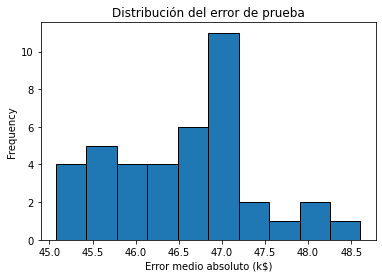

In [15]:
import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Error medio absoluto (k$)")
_ = plt.title("Distribución del error de prueba")

Observamos que el error de prueba se agrupa en torno a 47 k y un rango de entre 45 k y 48.5 k.

In [16]:
print(f"El error medio de validación cruzada es: "
      f"{cv_results['test_error'].mean():.2f} k$")

El error medio de validación cruzada es: 46.53 k$


In [17]:
print(f"La desviación típica de validación cruzada es: "
      f"{cv_results['test_error'].std():.2f} k$")

La desviación típica de validación cruzada es: 0.83 k$


Observemos que la desviación típica es mucho más pequeña que la media. Podemos resumirlo como que nuestra estimación de validación cruzada del error de prueba es de 46.53 +/- 0.83 k$. Si tuviéramos que entrenar un único modelo en el dataset completo (sin validación cruzada) y luego después tuviéramos acceso a una cantidad ilimitada de datos de prueba, cabría esperar que el error de prueba verdadero cayera dentro de esa región.

Aunque esta información es interesante por sí misma, debería ser contrastada con la escala de la variabilidad natural del vector `objetivo` de nuestro dataset. Vamos a dibujar la distribución de esta variable objetivo:

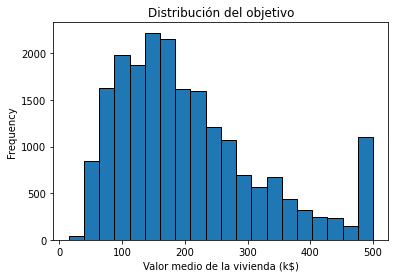

In [18]:
y.plot.hist(bins=20, edgecolor="black")
plt.xlabel("Valor medio de la vivienda (k$)")
_ = plt.title("Distribución del objetivo")

In [19]:
print(f"La desviación típica del objetivo es: {y.std():.2f} k$")

La desviación típica del objetivo es: 115.40 k$


El rango de la variable objetivo varía desde cercano a 0 hasta 500, con una desviación típica de 115. Remarquemos que la media estimada del error de prueba obtenido por validación cruzada es un poco más pequeño que la escala natural de variación de la variable objetivo. Además, la desviación típica de la validación cruzada estimada del error de prueba es incluso más pequeña. Esto es un buen comienzo, pero no necesariamente suficiente para decidir si el rendimiento de generalización es suficientemente bueno para que nuestra predicción sea útil en la práctica.

Recordemos que nuestro modelo tiene, de media, un error de alrededor de 47 k. Con esta información y mirando la distribución del objetivo, tal error podría ser aceptable cuando predecimos viviendas con un valor de 500 k. Sin embargo, sería un problema con una vivienda con un valor de 50 k. Por tanto, esto indica que nuestra métrica (Error Absoluto Medio) no es ideal.

En su lugar podríamos elegir una métrica relativa al valor del objetivo a predecir: el error porcentual absoluto medio habría sido una mejor opción. Pero en todos los casos, un error de 47 k podría ser demasiado grande para usar automáticamente nuestro modelo para etiquetar viviendas sin la supervisión de un experto.

## Más detalles sobre `cross_validate`

Durante la validación cruzada, se entrenan y evalúan muchos modelos. De hecho, el número de elementos de cada matriz de salida de `cross_validate` es el resultado de uno de estos procedimientos `fit` / `score`. Para hacer explícito, es posible recuperar estos modelos entrenados para cada una de las divisiones/particiones pasando la opción `return_estimator=True` en `cross_validate`.

In [20]:
cv_results = cross_validate(regressor, X, y, return_estimator=True)
cv_results

{'fit_time': array([0.15363216, 0.15012908, 0.15063   , 0.15063   , 0.14562511]),
 'score_time': array([0.00250292, 0.00250196, 0.00250196, 0.00250268, 0.00250244]),
 'estimator': (DecisionTreeRegressor(random_state=42),
  DecisionTreeRegressor(random_state=42),
  DecisionTreeRegressor(random_state=42),
  DecisionTreeRegressor(random_state=42),
  DecisionTreeRegressor(random_state=42)),
 'test_score': array([0.28326244, 0.4226389 , 0.45552292, 0.23727262, 0.41430376])}

In [21]:
cv_results["estimator"]

(DecisionTreeRegressor(random_state=42),
 DecisionTreeRegressor(random_state=42),
 DecisionTreeRegressor(random_state=42),
 DecisionTreeRegressor(random_state=42),
 DecisionTreeRegressor(random_state=42))

Los cinco regresores de árbol de decisión corresponden a los cinco árboles de decisión entrenados en las diferentes particiones. Tener acceso a estos regresores es útil porque permite inspeccionar los parametros entrenados internos de estos regresores.

En el caso de solo estemos interesados en la puntuación de prueba, scikit-learn provee una función `cross_val_score`. Es idéntica a llamar a la función `cross_validate` y seleccionar solo `test_score`.

In [22]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, X, y)
scores

array([0.28326244, 0.4226389 , 0.45552292, 0.23727262, 0.41430376])

# Overfit-generalización-underfit

Anteriormente presentamos el frameword de validación cruzada general y cómo nos ayuda e cuantificar los errores de entrenamiento y prueba así como sus fluctuaciones.

Ahora pondremos estos errores en perspectiva y mostraremos cómo nos pueden ayudar a saber si nuestro modelo generaliza, se produce overfitting o underfitting.

Usaremos de nuevo el mismo dataset y crearemos el mismo modelo que anteriormente.

In [23]:
housing = fetch_california_housing(as_frame=True)
X, y = housing.data.copy(), housing.target.copy()
y *= 100

In [24]:
regressor = DecisionTreeRegressor()

## Overfittin vs underfitting

Para comprender mejor el rendimiento de generalización de nuestro modelo y encontrar quizás alguna percepción de cómo mejorarlo, compararemos el error de prueba con el error de entrenamiento. Por tanto, necesitamos calcular el error en el conjunto de entrenamiento, lo cual es posible utilizando la función `cross_validate`.

In [25]:
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=42)
cv_results = cross_validate(regressor, X, y,
                            cv=cv, scoring="neg_mean_absolute_error",
                            return_train_score=True, n_jobs=-1
)
cv_results = pd.DataFrame(cv_results)

La validación cruzada usa el error absoluto medio negativo. Lo transformamos a positivo:

In [26]:
scores = pd.DataFrame()
scores[["train_error", "test_error"]] = -cv_results[
    ["train_score", "test_score"]
]

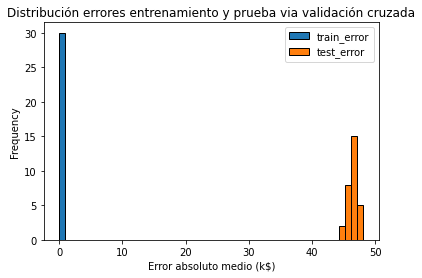

In [27]:
scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Error absoluto medio (k$)")
_ = plt.title("Distribución errores entrenamiento y prueba via validación cruzada")

Al dibujar la distribución de los errores de entrenamiento y prueba, obtenemos información sobre si en nuestro modelo se produce overfitting, underfitting o ambos a la vez.

Aquí observamos un **pequeño error de entrenamiento** (realmente cero), lo que significa que el modelo **no realiza underfitting**: es los suficientemente flexible para capturar cualquier variación presente en el conjunto de entrenamiento. Sin embargo, el **significativamente grande error de prueba** nos dice que sí existe overfitting: el modelo ha memorizado muchas variaciones del conjunto de entrenamiento que podrían considerarse "ruidosas" porque no generalizan para ayudarnos a realizar una buena predicción en el conjunto de prueba.

## Curva de validación

Algunos hiperparámetros del modelo suelen ser la clave para evolucionar de un modelo que realiza underfitting a un modelo que hace overfitting, con suerte pasando por una región donde podemos obtener un buen equilibrio entre los dos. Podemos adquirir conocimiento dibujando un curva llamada **curva de validación**. Esta curva también se puede aplicar al ejemplo anterior para variar el valor de un hiperparámetro.

Para un árbol de decisión, el paramétro `max_depth` se usa para controlar el equilibrio entre underfitting y overfitting.

In [28]:
%%time
from sklearn.model_selection import validation_curve

max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    regressor, X, y, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
)
train_errors, test_errors = -train_scores, -test_scores

Wall time: 1.86 s


Ahora que hemos coleccionado los resultados mostraremos la curva de validación dibujando los errores de entrenamiento y prueba (así como sus desviaciones).

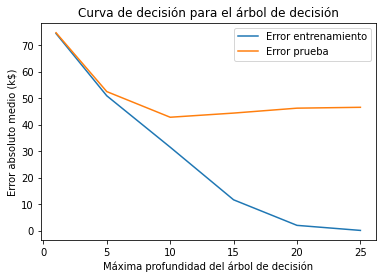

In [29]:
plt.plot(max_depth, train_errors.mean(axis=1), label="Error entrenamiento")
plt.plot(max_depth, test_errors.mean(axis=1), label="Error prueba")
plt.legend()

plt.xlabel("Máxima profundidad del árbol de decisión")
plt.ylabel("Error absoluto medio (k$)")
_ = plt.title("Curva de decisión para el árbol de decisión")

La curva de validación se puede dividir en 3 zonas:

+ Para `max_depth < 10`, el árbol de decisión produce underfitting. Tanto el error de entrenamiento como el de prueba son altos. El modelo es demasiado restrictivo y no puede capturar muchas de la variabilidad de la variable objetivo.

+ La región alrededor de `max_depth = 10` corresponde con el parámetro para el cual el árbol de decisión generaliza mejor. Es lo suficientemente flexible para capturar una fracción de la variabilidad del objetivo que se generaliza, mientras que no memoriza todo el ruido en el objetivo.

+ Para `max_depth > 10`, el árbol de decisión produce overfitting. El error de entrenamiento se convierte en muy pequeño, mientras que el error de prueba incrementa. En esta región, los modelos crean decisiones específicamente para muestras ruidosas que dañan su capacidad para generalizar a los datos de prueba.

Observemos que para `max_depth = 10` el modelo produce un poco de overfitting ya que hay una brecha entre el error de entrenamiento y el error de prueba. Al mismo tiempo también produce underfitting ya que el error de entrenamiento aún está lejos de cero (más de 30 k), lo que significa que el modelo aún podría estar limitado para modelar partes interesantes de los datos. Sin embargo, el error de prueba es mínimo y esto es lo que realmente inmporta. Este es el mejor compromiso que podemos alcanzar ajustando únicamente este hiperparámetro.

Tengamos en cuenta que mirar los errores medios es bastante limitante. También debemos observar la desviación típica para comprobar la dispersión de la puntuación. Podemos repetir el mismo gráfico de antes, pero añadiendo alguna información para mostrar también la desviación típica de los errores.

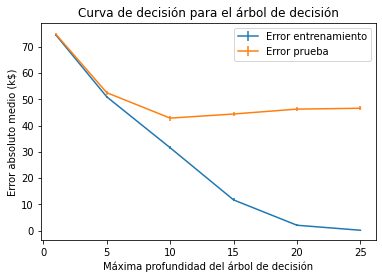

In [30]:
plt.errorbar(max_depth, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Error entrenamiento")
plt.errorbar(max_depth, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Error prueba")
plt.legend()

plt.xlabel("Máxima profundidad del árbol de decisión")
plt.ylabel("Error absoluto medio (k$)")
_ = plt.title("Curva de decisión para el árbol de decisión")

Tuvimos suerte de que la varianza de los errores fuera pequeña en comparación con sus respectivos valores, por tanto las conclusiones anteriores son claras, aunque esto no es necesariamente siempre el caso.

# Efecto del tamaño de la muestra en la validación cruzada

Hemos visto anteriormente el framework de validación cruzada general y cómo evaluar si en un modelo se produce underfitting, overfitting o generalización. Además de estos aspectos, también es importante comprender cómo los diferentes errores se ven influenciados por el número de muestras disponibles. Vamos a mostrar este aspecto al observar la variablidad de los diferentes errores.

Partimos del mismo dataset y modelo que teníamos anteriormente (`X`, `y` y `regressor`)

## Curva de aprendizaje

Para comprender el impacto del número de muestras disponibles para entrenamiento en el rendimiento de generalización de un modelo predictivo, es posible reducir sintéticamente el número de muestras usadas para entrenar el modelo predictivo y verificar los errores de entrenamiento y prueba.

Por tanto, podemos variar el número de muestras del conjunto de entrenamiento y repetir el entrenamiento. Las puntuaciones de entrenamiento y prueba de pueden dibujar de forma similar a la curva de validación, pero en lugar de variar un hiperparámetro, variamos el número de muestra de entrenamiento. Esta curva se llama **curva de aprendizaje**. Proporciona información sobre el beneficio de añadir nuevas muestras de entrenamiento para mejorar el rendimiento de generalización de un modelo.

Vamos a calcular la curva de aprendizaje de un árbol de decisión y a variar la proporción del conjunto de entrenamiento del 10% al 100%.

In [31]:
import numpy as np

train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

Usaremos `ShuffleSplit` de validación cruzada para evaluar nuestro modelo predictivo.

In [32]:
cv = ShuffleSplit(n_splits=30, test_size=0.2)

Ahora ya tenemos todo configurado para comenzar el experimento.

In [33]:
from sklearn.model_selection import learning_curve

results = learning_curve(
    regressor, X, y, train_sizes=train_sizes, cv=cv,
    scoring="neg_mean_absolute_error", n_jobs=-1
)
train_size, train_scores, test_scores = results[:3]
# Convierte las puntuaciones en errores
train_errors, test_errors = -train_scores, -test_scores

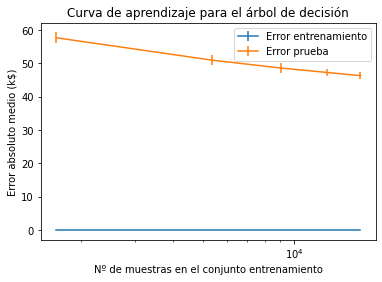

In [34]:
plt.errorbar(train_size, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Error entrenamiento")
plt.errorbar(train_size, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Error prueba")
plt.legend()

plt.xscale("log")
plt.xlabel("Nº de muestras en el conjunto entrenamiento")
plt.ylabel("Error absoluto medio (k$)")
_ = plt.title("Curva de aprendizaje para el árbol de decisión")

Observando por separado el error de entrenamiento, vemos que obtenemos un error de 0 k. Lo que significa que en el modelo produce claramente overfitting de los datos de entrenamiento.

Observando por separado el error de prueba, vemos que cuantas más muestras se añaden al conjunto de entrenamiento, menor es el error de prueba. Además, estamos buscando la meseta del error de prueba para la cual ya no existe beneficio de seguir añadiendo muestras o evaluar la potencial ganancia de añadir más muestras en el conjunto de entrenamiento. Si alcanzamos una meseta y añadir nuevas muestras al conjunto de entrenamiento no reduce el error de prueba, es posible que hayamos alcanzado la tasa de error de Bayes utilizando el modelo disponible. El uso de un modelo más complejo podría ser la única posibilidad de reducir aún más el error de prueba.

# Resumen

+ El **overfitting** es causado por el tamaño limitado del conjunto de entrenamiento, el ruido en los datos y la alta flexibilidad de los modelos de machine learning comunes.

+ El **underfitting** sucede cuando las funciones de predicción aprendidas sufren de **errores sistemáticos**. Esto se puede producir por la elección de la familia del modelo y los parámetros, lo cuales conducen a una **carencia de flexibilidad** para capturar la estructura repetible del verdadero proceso de generación de datos.

+ Para un conjunto de entrenamiento dado, el objetivo es **minimizar el error de preba** ajustando la familia del modelo y sus parámetros para encontrar el **mejor equilibrio entre overfitting y underfitting**.

+ Para una familia de modelo y parámetros dados, **incrementar el tamaño del conjunto de entrenamiento disminuirá el overfitting**, pero puede causar un incremento del underfitting.

+ El error de prueba de un modelo que no tiene overfitting ni underfitting puede ser alto todavía si las variaciones de la variable objetivo no pueden ser determinadas completamente por las variables de entrada. Este error irreductible es causado por lo que algunas veces llamamos error de etiqueta. En la práctica, esto sucede a menudo cuando por una razón u otra no tenemos acceso a features importantes.

Algunas referencias a seguir con ejemplos de algunos conceptos mencionados:

+ [Ilustración de los conceptos de underfitting y overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py).
+ [Diferencia entre puntuación de entrenamiento y prueba](https://scikit-learn.org/stable/auto_examples/model_selection/plot_train_error_vs_test_error.html#sphx-glr-auto-examples-model-selection-plot-train-error-vs-test-error-py).
+ [Ejemplo de curva de validación](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py)